# CNN for CIFAR dataset recognition

- 10 classes
- 3 channel images
- typically repeat pattern:convolution -> pooling -> fully connected layer
- insert batch normalization, dropout and see what happens

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model

from sklearn.metrics import confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
cifar = tf.keras.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0   # standarize (0,1)
y_train, y_test = y_train.flatten(), y_test.flatten()
print(f"X_train: {x_train.shape}")
print(f"Y_train: {y_train.shape}")

X_train: (50000, 32, 32, 3)
Y_train: (50000,)


In [ ]:
K = len(set(y_train)) # unique elements of y_train (10 classes should be)
K

10

## Build and train CNN

In [ ]:
# functional API
i = Input(shape=x_train[0].shape)

x = Conv2D(32, (3,3), activation='relu', padding='same')(i) # without same padding the images are going to shrink after each convolutiuon
x = BatchNormalization()(x)
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
# x = Dropout(0.2)(x)   # dropout may change the actual image, but if it works it works

x = Conv2D(64, (3,3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
# x = Dropout(0.2)(x)

x = Conv2D(128, (3,3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
# x = Dropout(0.2)(x)

x = GlobalMaxPooling2D()(x)     # bc Dense expects 1D object...
x = Flatten()(x)                #...flatten makes it 1D but it makes sense only when all images are the same size
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x) # fully connected layer, neuron
x = Dropout(0.2)(x)
x = Dense(K, activation='softmax')(x) # K=10 output labels

model = Model(i, x)

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

r = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50)

Epoch 1/50
1563/1563 [==============================] - 16s 10ms/step - loss: 1.8719 - accuracy: 0.3103 - val_loss: 1.7329 - val_accuracy: 0.3834
Epoch 2/50
1563/1563 [==============================] - 15s 10ms/step - loss: 1.6139 - accuracy: 0.4081 - val_loss: 1.5126 - val_accuracy: 0.4424
Epoch 3/50
1563/1563 [==============================] - 15s 10ms/step - loss: 1.4964 - accuracy: 0.4546 - val_loss: 1.3765 - val_accuracy: 0.5067
Epoch 4/50
1563/1563 [==============================] - 16s 10ms/step - loss: 1.4239 - accuracy: 0.4863 - val_loss: 1.5057 - val_accuracy: 0.4638
Epoch 5/50
1563/1563 [==============================] - 15s 10ms/step - loss: 1.3728 - accuracy: 0.5038 - val_loss: 1.3042 - val_accuracy: 0.5306
Epoch 6/50
1563/1563 [==============================] - 15s 10ms/step - loss: 1.3256 - accuracy: 0.5264 - val_loss: 1.2493 - val_accuracy: 0.5505
Epoch 7/50
1563/1563 [==============================] - 18s 11ms/step - loss: 1.2850 - accuracy: 0.5401 - val_loss: 1.2619 -

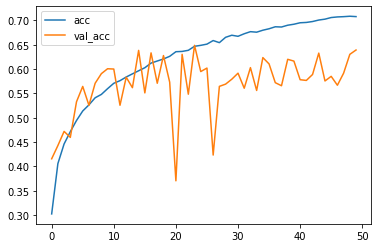

In [ ]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

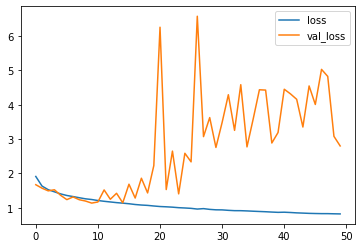

In [ ]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

## Data augmentation

Use ImageDataGenerator to extract even more from CIFAR dataset

In [ ]:
batch_size = 32
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(x_train, y_train, batch_size)
r = model.fit_generator(train_generator, validation_data=(x_test, y_test), steps_per_epoch=x_train.shape[0] // batch_size, epochs=50)

In [ ]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [ ]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

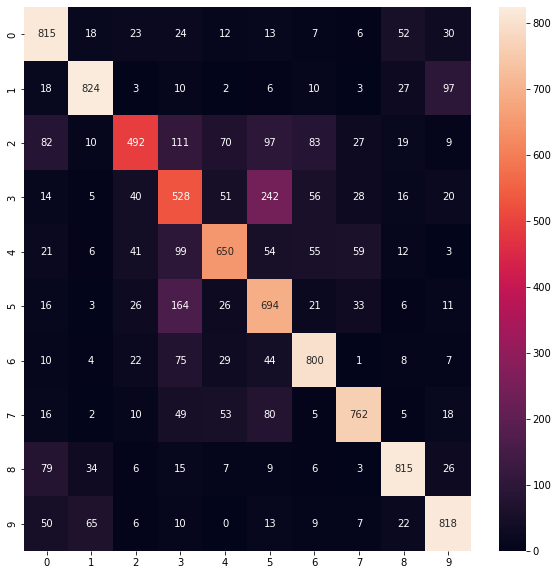

In [ ]:
p_test = model.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)
plt.figure(figsize = (10,10))
sns.heatmap(cm, annot=True, fmt='g')

Text(0.5, 1.0, 'True label: bird Predicted: frog')

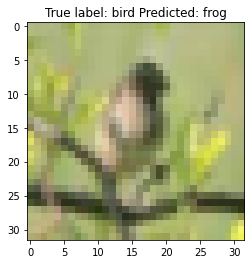

In [ ]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i], cmap='gray')
plt.title("True label: %s Predicted: %s" % (labels[y_test[i]], labels[p_test[i]]))

In [ ]:
 model.summary()